# Comparison of operations woth OOMMF

In [19]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np

Skyrmion field

Running OOMMF (ExeOOMMFRunner) [2020/06/06 01:20]... (1.7 s)


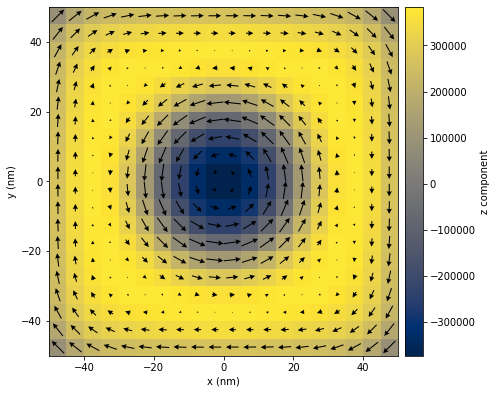

In [26]:
# Geometry
L = 100e-9
thickness = 5e-9
cell = 3*(5e-9,)

p1 = (-L/2, -L/2, 0)
p2 = (L/2, L/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc='neumann')

# Energy equation
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
K = 1e4
u = (0, 0, 1)
H = (0, 0, 1e5)
system = mm.System(name='skyrmion')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T') + mm.Zeeman(H=H) + mm.UniaxialAnisotropy(K=K, u=u)

def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (L/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, dim=3, value=m_initial, norm=Ms)

md = oc.MinDriver()
md.drive(system)

system.m.plane('z').mpl(figsize=(7, 7))

## Magnetisation

In [29]:
m = system.m.orientation

## Zeeman

#### Energy density

In [30]:
wdf = - mu0 * Ms * m @ H
woc = oc.compute(system.energy.zeeman.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/06 01:21]... (1.9 s)


True

#### Energy

In [31]:
Edf = (- mu0 * Ms * m @ H).integral
Eoc = oc.compute(system.energy.zeeman.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/06 01:21]... (1.8 s)
df: -1.5113010526414388e-18
oc: -1.51130105264e-18
rerr: -9.520685894692345e-11 %


#### Effective field

In [32]:
Hdf = df.Field(mesh, dim=3, value=H)
Hoc = oc.compute(system.energy.zeeman.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/06 01:21]... (1.8 s)


True

## Uniaxial anisotropy

#### Energy density

In [37]:
wdf = - K * (m @ u)**2
woc = oc.compute(system.energy.uniaxialanisotropy.density, system)
np.allclose(wdf.array, woc.array)

wdf.array[0, 0, 0, :]

Running OOMMF (ExeOOMMFRunner) [2020/06/06 01:22]... (1.8 s)


array([-519.95841293])

In [38]:
woc.array[0, 0, 0, :]

array([9480.04158707])

#### Energy

In [10]:
Edf = (K * (m @ u)**2).integral
Eoc = oc.compute(system.energy.uniaxialanisotropy.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (2.2 s)
df: 8.353846153846153e-41
oc: 4e-22
rerr: 4.788213627992634e+20 %


#### Effective field

In [11]:
Hdf = 2 * K / (mu0 * Ms) * (m @ u)
Hoc = oc.compute(system.energy.uniaxialanisotropy.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (2.1 s)


False

## Exchange

#### Energy density

In [13]:
wdf = - A * m @ m.laplace
woc = oc.compute(system.energy.exchange.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (2.0 s)


True

#### Energy

In [14]:
Edf = (- A * m @ m.laplace).integral
Eoc = oc.compute(system.energy.exchange.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (1.9 s)
df: 2.2966915816200814e-22
oc: 2.29669158162e-22
rerr: 3.5417994182537243e-12 %


#### Effective field

In [15]:
Hdf = 2 * A / (mu0 * Ms) * m.laplace
Hoc = oc.compute(system.energy.exchange.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (1.8 s)


True

## DMI

#### Energy density

In [16]:
wdf = D * m @ m.curl
woc = oc.compute(system.energy.dmi.density, system)
np.allclose(wdf.array, woc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (1.8 s)


True

#### Energy

In [17]:
Edf = (D * m @ m.curl).integral
Eoc = oc.compute(system.energy.dmi.energy, system)
print(f'df: {Edf}')
print(f'oc: {Eoc}')
print(f'rerr: {abs(Edf-Eoc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:27]... (1.8 s)
df: 3.1335917485584463e-31
oc: 3.13359174856e-31
rerr: 4.958175145294178e-11 %


#### Effective field

In [18]:
Hdf = - 2 * D / (mu0 * Ms) * m.curl
Hoc = oc.compute(system.energy.dmi.effective_field, system)
np.allclose(Hdf.array, Hoc.array)

Running OOMMF (ExeOOMMFRunner) [2020/06/04 21:28]... (1.8 s)


False

In [ ]:
Hdf.array

In [ ]:
Hoc.array